In [4]:
import numpy as np
import pandas as pd
import math
import requests 
import matplotlib as plt
import seaborn as sns
import yfinance as yf
import pandas_datareader as web
from pandas_datareader import data
from bs4 import BeautifulSoup as bs
from scipy import stats

In [23]:
#Create first table with all stock info from yfinance =
tick = pd.read_csv("all_stocks")
columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Ticker']
final = pd.DataFrame(columns = columns)
for i in range(len(tick)): 
    ticker = tick["0"][i]
    info = yf.Ticker(ticker).history(period='max')
    info.reset_index(inplace = True)
    info['Ticker'] = ticker
    final = pd.concat([final, info])

<AxesSubplot:xlabel='Date', ylabel='Close'>

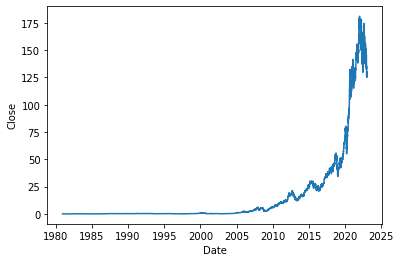

In [11]:
sns.lineplot(x = 'Date', y = 'Close', data = info)